In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split, Dataset
import os
import pickle
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import cv2

In [2]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=False):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        # Skip connection with 1x1 convolution when downsampling
        self.downsample = downsample
        if downsample:
            self.skip_conv = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False)
            self.skip_bn = nn.BatchNorm2d(out_channels)
        else:
            self.skip_conv = None

    def forward(self, x):
        identity = x
        if self.downsample:
            identity = self.skip_bn(self.skip_conv(x))

        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += identity  
        return F.relu(out)

In [3]:
class CustomResNet(nn.Module):
    def __init__(self, num_classes=10):
        super(CustomResNet, self).__init__()

        # Initial Convolution (C1 = 32 channels)
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(32)

        # Residual layers with Max Pooling after each layer
        self.layer1 = self._make_layer(32, 32, num_blocks=2, stride=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=1)  # Max pooling after layer1

        self.layer2 = self._make_layer(32, 64, num_blocks=2, stride=2)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=1)  # Max pooling after layer2

        self.layer3 = self._make_layer(64, 128, num_blocks=2, stride=2)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=1)  # Max pooling after layer3

        self.layer4 = self._make_layer(128, 256, num_blocks=2, stride=2)

        # Average Pooling (Final layer)
        self.avgpool = nn.AvgPool2d(kernel_size=2, stride=2)

        # Fully Connected Layers
        self.fc = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(1024, 800),  # First FC layer
            nn.ReLU(),
            nn.Linear(800, num_classes)  # Output layer
        )

    def _make_layer(self, in_channels, out_channels, num_blocks, stride):
        layers = []
        layers.append(ResidualBlock(in_channels, out_channels, stride=stride, downsample=True))
        layers.append(ResidualBlock(out_channels, out_channels, stride=1, downsample=False))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))

        x = self.layer1(x)
        x = self.pool1(x)  # Apply max pooling after layer1

        x = self.layer2(x)
        x = self.pool2(x)  # Apply max pooling after layer2

        x = self.layer3(x)
        x = self.pool3(x)  # Apply max pooling after layer3

        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [5]:
model = CustomResNet().to(device)

In [6]:
from torchsummary import summary

# Move model to the correct device (CPU or GPU)
model.to(device)

# Print model summary (assuming input image size is 3×32×32 for CIFAR-10)
summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             864
       BatchNorm2d-2           [-1, 32, 32, 32]              64
            Conv2d-3           [-1, 32, 32, 32]           1,024
       BatchNorm2d-4           [-1, 32, 32, 32]              64
            Conv2d-5           [-1, 32, 32, 32]           9,216
       BatchNorm2d-6           [-1, 32, 32, 32]              64
            Conv2d-7           [-1, 32, 32, 32]           9,216
       BatchNorm2d-8           [-1, 32, 32, 32]              64
     ResidualBlock-9           [-1, 32, 32, 32]               0
           Conv2d-10           [-1, 32, 32, 32]           9,216
      BatchNorm2d-11           [-1, 32, 32, 32]              64
           Conv2d-12           [-1, 32, 32, 32]           9,216
      BatchNorm2d-13           [-1, 32, 32, 32]              64
    ResidualBlock-14           [-1, 32,

In [7]:
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [8]:
def load_cifar10_batches():
    train_data = []
    train_labels = []
    
    for i in range(1, 6):  # data_batch_1 to data_batch_5
        batch_file = os.path.join(data_dir, f"data_batch_{i}")
        batch_dict = unpickle(batch_file)
        
        batch_data = batch_dict[b'data']  # Image data (10000, 3072)
        batch_labels = batch_dict[b'labels']  # Labels (10000,)
        
        train_data.append(batch_data)
        train_labels.extend(batch_labels)
    
    train_data = np.vstack(train_data).reshape(-1, 3, 32, 32).astype(np.float32)
    train_labels = np.array(train_labels)
    
    return train_data, train_labels

In [9]:
def load_cifar10_test():
    test_file = os.path.join(data_dir, "test_batch")
    test_dict = unpickle(test_file)
    
    test_data = test_dict[b'data'].reshape(-1, 3, 32, 32).astype(np.float32)
    test_labels = np.array(test_dict[b'labels'])
    
    return test_data, test_labels

In [10]:
class CIFAR10Dataset(Dataset):
    def __init__(self, data, labels, transform=None):
        self.data = data # (N, 3, 32, 32)
        self.labels = torch.tensor(labels, dtype=torch.long)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img = np.transpose(self.data[idx], (1, 2, 0))  # (3, 32, 32) -> (32, 32, 3)

        # to PIL
        img = Image.fromarray(img.astype(np.uint8))

        label = self.labels[idx]
        if self.transform:
            img = self.transform(img)
        return img, label

In [11]:
def test(model, test_loader, device):
    model.eval()  # Set model to evaluation mode
    correct, total = 0, 0
    
    with torch.no_grad():  # Disable gradient computation
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)  # Get predicted class
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    test_acc = 100 * correct / total
    print(f"Test Accuracy: {test_acc:.2f}%")
    return test_acc

In [12]:
data_dir = "./data/cifar-10-batches-py"

In [13]:
# Load Data
train_data, train_labels = load_cifar10_batches()
test_data, test_labels = load_cifar10_test()

# Split Training Set into Training & Validation (80% Train, 20% Validation)
train_size = int(0.8 * len(train_data))
val_size = len(train_data) - train_size
train_data, val_data = train_data[:train_size], train_data[train_size:]
train_labels, val_labels = train_labels[:train_size], train_labels[train_size:]

transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

# Create Dataset & DataLoader
train_dataset = CIFAR10Dataset(train_data, train_labels, transform=transform)
val_dataset = CIFAR10Dataset(val_data, val_labels, transform=transform)
test_dataset = CIFAR10Dataset(test_data, test_labels, transform=transform)

print(train_dataset[0])

batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

print(f"Loaded CIFAR-10: {len(train_dataset)} train, {len(val_dataset)} val, {len(test_dataset)} test samples.")

(tensor([[[-2.4291, -2.4291, -2.4291,  ..., -2.4291, -2.4291, -2.4291],
         [-2.4291, -2.4291, -2.4291,  ..., -2.4291, -2.4291, -2.4291],
         [-2.4291, -2.4291, -2.4291,  ..., -2.4291, -2.4291, -2.4291],
         ...,
         [-2.4291, -2.4291,  0.1491,  ...,  0.2461,  0.4011,  0.9633],
         [-2.4291, -2.4291, -0.9364,  ...,  0.4787,  0.9633,  1.3510],
         [-2.4291, -2.4291, -1.8475,  ...,  1.0602,  1.4479,  1.7775]],

        [[-2.4183, -2.4183, -2.4183,  ..., -2.4183, -2.4183, -2.4183],
         [-2.4183, -2.4183, -2.4183,  ..., -2.4183, -2.4183, -2.4183],
         [-2.4183, -2.4183, -2.4183,  ..., -2.4183, -2.4183, -2.4183],
         ...,
         [-2.4183, -2.4183, -0.5302,  ..., -0.7662, -0.7072, -0.1959],
         [-2.4183, -2.4183, -1.4349,  ..., -0.4909,  0.0794,  0.3154],
         [-2.4183, -2.4183, -2.1429,  ...,  0.2761,  0.7284,  0.9251]],

        [[-2.2214, -2.2214, -2.2214,  ..., -2.2214, -2.2214, -2.2214],
         [-2.2214, -2.2214, -2.2214,  ..., -

In [ ]:
num_epochs = 150
criterion = nn.CrossEntropyLoss()
#optimizer = optim.Adam(model.parameters(), lr=0.001)
optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)
best_val_acc = 0.0


for epoch in range(num_epochs):
    print(f"\n Epoch {epoch+1}/{num_epochs} ---------------------------")
    
    ### TRAINING PHASE ###
    model.train()
    running_loss = 0.0
    correct, total = 0, 0
    
    for batch_idx, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # Track loss
        running_loss += loss.item()
        
        # Track accuracy
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

        # Print loss for every 50 batches
        if (batch_idx + 1) % 50 == 0 or (batch_idx + 1) == len(train_loader):
            print(f"[Batch {batch_idx+1}/{len(train_loader)}] Loss: {loss.item():.4f}")
    # Calculate training accuracy
    train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct / total
    print(f"Training Loss: {train_loss:.4f}, Training Accuracy: {train_acc:.2f}%")
    scheduler.step()
    current_lr = optimizer.param_groups[0]['lr']
    print(f" Learning Rate after Epoch {epoch+1}: {current_lr:.6f}")
    
    ### VALIDATION PHASE ###
    model.eval()
    correct, total = 0, 0
    
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    val_acc = 100 * correct / total
    print(f"Validation Accuracy: {val_acc:.2f}%")

    ### SAVE BEST MODEL ###
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_model.pth")
        print(f"Best model saved with Validation Accuracy: {best_val_acc:.2f}%")

print("\n Training Completed!")



🔄 Epoch 1/150 ---------------------------
[Batch 50/313] Loss: 2.0553
[Batch 100/313] Loss: 1.7704
[Batch 150/313] Loss: 1.8465
[Batch 200/313] Loss: 1.7318
[Batch 250/313] Loss: 1.7540
[Batch 300/313] Loss: 1.4727
[Batch 313/313] Loss: 1.5743
Training Loss: 1.8015, Training Accuracy: 32.84%
 Learning Rate after Epoch 1: 0.099989
Validation Accuracy: 37.95%
Best model saved with Validation Accuracy: 37.95%

🔄 Epoch 2/150 ---------------------------
[Batch 50/313] Loss: 1.5946
[Batch 100/313] Loss: 1.3130
[Batch 150/313] Loss: 1.1349
[Batch 200/313] Loss: 1.2104
[Batch 250/313] Loss: 1.1360
[Batch 300/313] Loss: 0.8090
[Batch 313/313] Loss: 1.0740
Training Loss: 1.2684, Training Accuracy: 53.98%
 Learning Rate after Epoch 2: 0.099956
Validation Accuracy: 53.92%
Best model saved with Validation Accuracy: 53.92%

🔄 Epoch 3/150 ---------------------------
[Batch 50/313] Loss: 1.0790
[Batch 100/313] Loss: 0.9255
[Batch 150/313] Loss: 1.0972
[Batch 200/313] Loss: 1.1526
[Batch 250/313] Loss

In [15]:
# Test
model.load_state_dict(torch.load("best_model.pth"))
model.to(device)
model.eval()
test(model, test_loader, device)

Test Accuracy: 93.29%


93.29

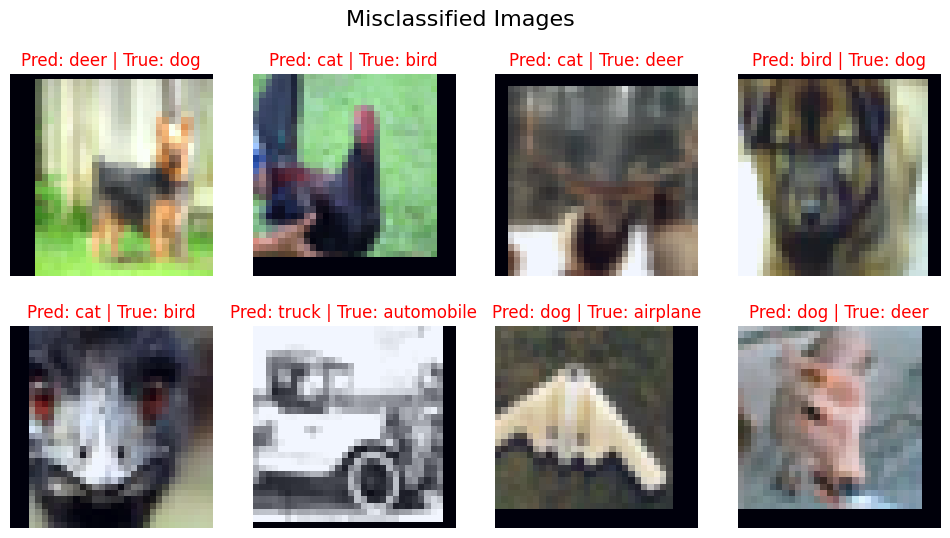

In [16]:
# Extract 8 misclassify images, to analyze error
class_names = ['airplane', 'automobile', 'bird', 'cat', 
               'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

model.load_state_dict(torch.load("best_model.pth"))
model.to(device)
model.eval()

wrong_images = []
wrong_labels = []
wrong_preds = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        
        for i in range(len(labels)):
            if preds[i] != labels[i]: 
                wrong_images.append(images[i].cpu().numpy())
                wrong_labels.append(class_names[labels[i].cpu().item()])
                wrong_preds.append(class_names[preds[i].cpu().item()])
                
            if len(wrong_images) >= 8:
                break
        if len(wrong_images) >= 8:
            break

fig, axes = plt.subplots(2, 4, figsize=(12, 6))
fig.suptitle("Misclassified Images", fontsize=16)

for i, ax in enumerate(axes.flat):
    img = wrong_images[i].transpose(1, 2, 0)
    img = (img - img.min()) / (img.max() - img.min())

    ax.imshow(img)
    ax.set_title(f"Pred: {wrong_preds[i]} | True: {wrong_labels[i]}", color="red")
    ax.axis("off")

plt.show()


C:\Users\Ritchie\AppData\Local\Temp\ipykernel_7632\3385438585.py:49: RuntimeWarning: invalid value encountered in divide
  heatmap /= np.max(heatmap)  # 归一化
C:\Users\Ritchie\AppData\Local\Temp\ipykernel_7632\1329738319.py:45: RuntimeWarning: invalid value encountered in cast
  heatmap = np.uint8(255 * heatmap)


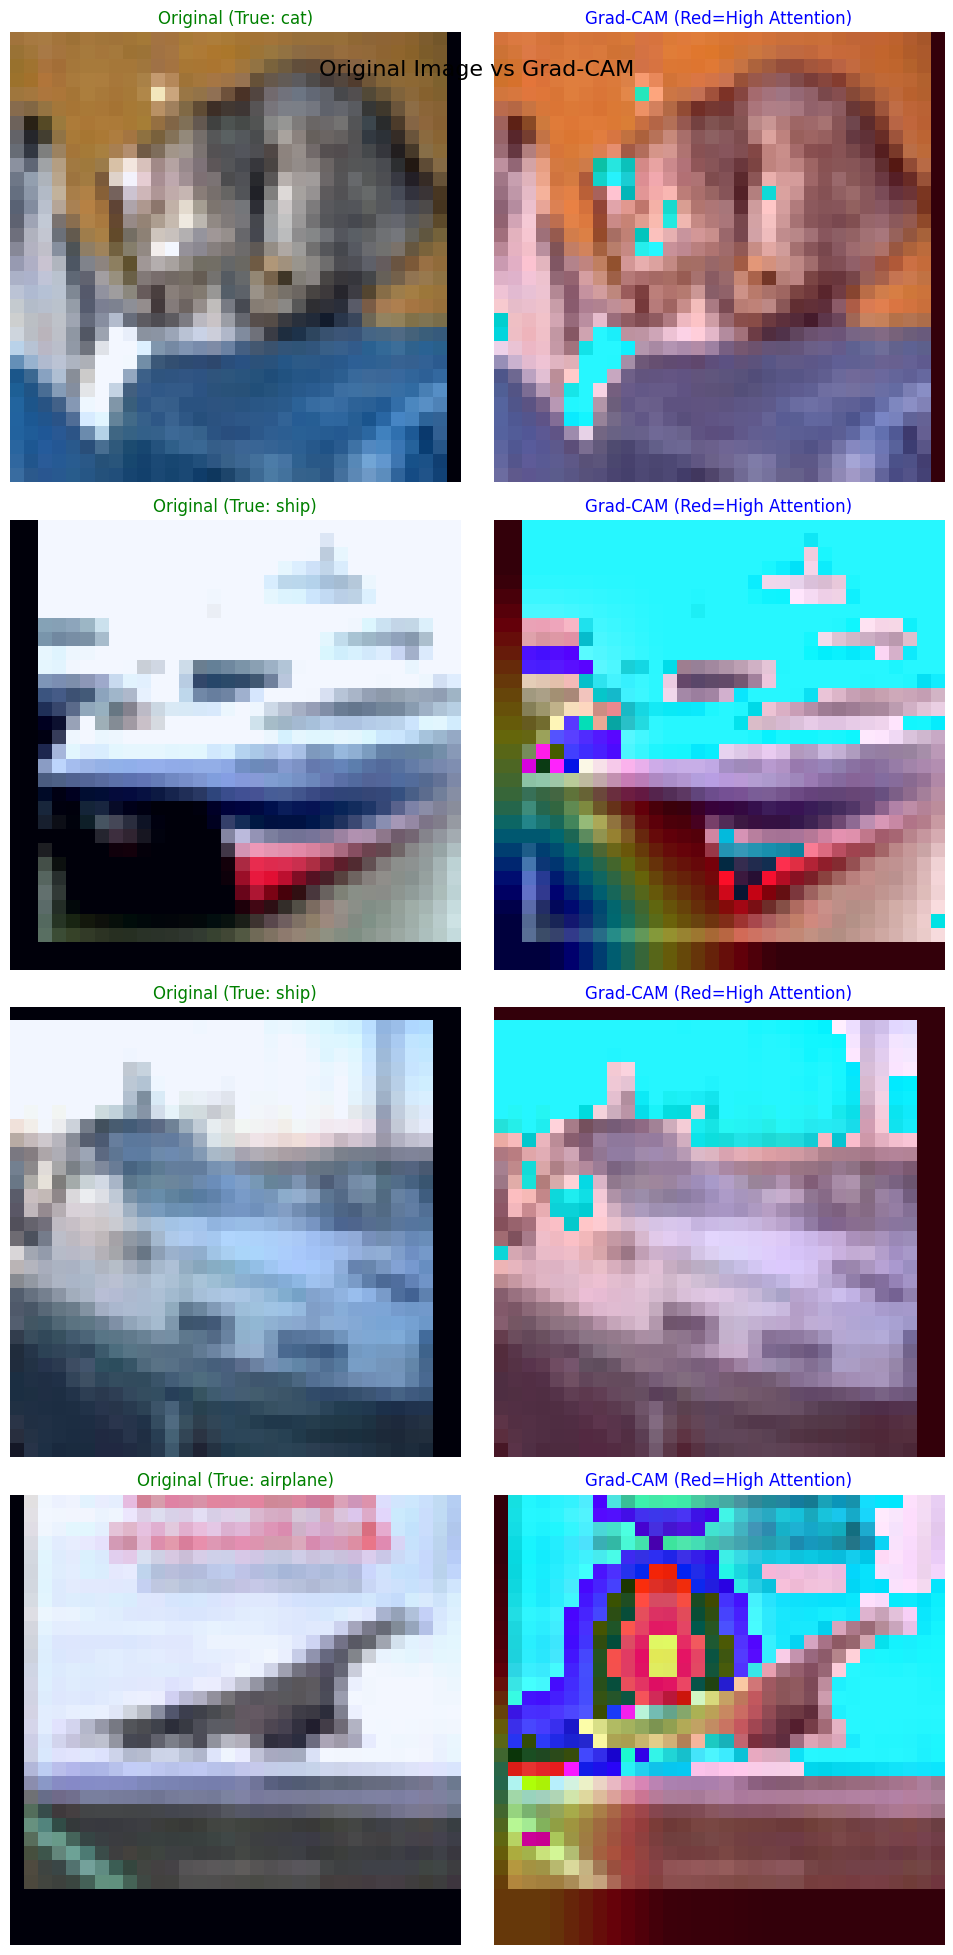

In [ ]:
def visualize_correct_predictions(model, test_loader, device, num_samples=4):
    # only visualize the first num_samples correct predictions
    model.eval()
    correct_images = []
    correct_labels = []
    
    # collect num_samples correct predictions
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            
            for i in range(len(labels)):
                if preds[i] == labels[i] and len(correct_images) < num_samples:
                    correct_images.append(images[i].cpu())
                    correct_labels.append(labels[i].cpu().item())
            
            if len(correct_images) >= num_samples:
                break
    
    # create Grad-CAM visualizations
    fig, axes = plt.subplots(num_samples, 2, figsize=(10, 5*num_samples))
    fig.suptitle("Original Image vs Grad-CAM", fontsize=16, y=0.95)
    
    for idx in range(num_samples):
        img = correct_images[idx]
        label = correct_labels[idx]
        
        # left: original image
        ax_orig = axes[idx, 0] if num_samples > 1 else axes[0]
        img_orig = img.numpy().transpose(1, 2, 0)
        img_orig = (img_orig - img_orig.min()) / (img_orig.max() - img_orig.min())
        ax_orig.imshow(img_orig)
        ax_orig.set_title(f"Original (True: {class_names[label]})", color='green')
        ax_orig.axis('off')
        
        # right: Grad-CAM heatmap
        ax_heatmap = axes[idx, 1] if num_samples > 1 else axes[1]
        heatmap = generate_gradcam(model, img.unsqueeze(0).to(device), label)
        
        if heatmap is not None:
            # 叠加热力图
            heatmap = cv2.resize(heatmap, (img_orig.shape[1], img_orig.shape[0]))
            heatmap = np.uint8(255 * heatmap)
            heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
            superimposed_img = heatmap * 0.4 + img_orig * 255  # 调整透明度
            
            ax_heatmap.imshow(superimposed_img.astype(np.uint8))
            ax_heatmap.set_title("Grad-CAM (Red=High Attention)", color='blue')
            ax_heatmap.axis('off')
    
    plt.tight_layout()
    plt.show()

# use the first 4 correct predictions
visualize_correct_predictions(model, test_loader, device, num_samples=4)

Number of images: 10000
Shape of image: (32, 32, 3)


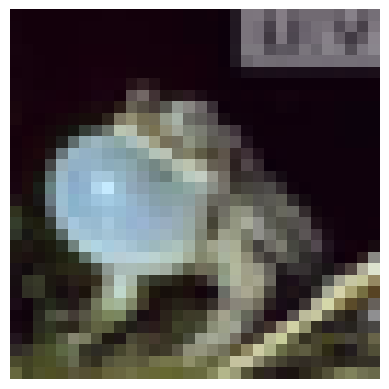

Finished!


In [18]:
import pickle
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms

from PIL import Image

# read the kaggle custom dataset
with open('./data/cifar_test_nolabel.pkl', 'rb') as f:
    data = pickle.load(f)

images = data[b'data']
ids = data[b'ids']

# print the number of images an the shape of image
print(f'Number of images: {len(images)}')
print(f'Shape of image: {images[0].shape}')

# convert the data to tensor
images = images.reshape(-1, 32, 32, 3).astype(np.float32)
images = images / 255.0

transform = transforms.Compose([
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

# convert the images to tensor
images = np.transpose(images, (0, 3, 1, 2))
images = torch.tensor(images, dtype=torch.float32)

images = torch.stack([transform(img) for img in images])


# Convert image tensor to a displayable format
def show_image(img_tensor):
    # Convert from (C, H, W) to (H, W, C) for displaying with matplotlib
    img = img_tensor.permute(1, 2, 0).numpy()

    # Normalize the image to [0, 1]
    img = (img - img.min()) / (img.max() - img.min())

    # Display the image
    plt.imshow(img)
    plt.axis('off')  # Hide axes for better image display
    plt.show()

# show the first n image to check
for _ in range(1):
    show_image(images[_])

# load the model
model = CustomResNet()
model.load_state_dict(torch.load('best_model.pth'))

# check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# predict the labels
model.eval()
predictions = []
with torch.no_grad():
    for inputs in images:
        inputs = inputs.unsqueeze(0).to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        predictions.append(predicted.item())

# save the predictions to a csv file
with open('submission.csv', 'w') as f:
    f.write('ID,Labels\n')
    for i, pred in zip(ids, predictions):
        f.write(f'{i},{pred}\n')

print("Finished!")
